# Daily IRI Parameters for given level of solar activity for a single location

In case you are interested in a single location (as opposed to the grid)
PyIRI can evaluate parameters at this location if it is passed as a 1-element
NumPy array. 

1. Import libraries:

In [1]:
import numpy as np
import PyIRI
import PyIRI.edp_update as ml
import PyIRI.plotting as plot

2. Specify a year, a month, and a day:

In [2]:
year = 2020
month = 4
day = 1

3. Specify solar flux index F10.7 in SFU:

In [3]:
f107 = 100

4. Specify what coefficients to use for the peak of F2 layer:

In [4]:
ccir_or_ursi = 0

5. Create a horizontal grid with a single location of interest.
E.g. lon = 10 E, lat = 20 N. 

In [5]:
alon = np.array([10.])
alat = np.array([20.])

6. Create any temporal array expressed in decimal hours (regular or irregular).
In case you are interested in only one time frame, it also needs to be presented as
NumPy array with a single element. 
For this example we are using regularly spaced time array:

In [6]:
hr_res = 0.25
ahr = np.arange(0, 24, hr_res)

12. Create height array. It can be regular or irregular.
Here is an example for regularly spaced array:

In [7]:
alt_res = 1
alt_min = 90
alt_max = 700
aalt = np.arange(alt_min, alt_max, alt_res)

7. Find ionospheric parameters for F2, F1, E, and Es regions by
calling IRI_density_1day function:

In [8]:
f2, f1, e_peak, es_peak, sun, mag, edp = ml.IRI_density_1day(year, month, day, ahr, alon, alat, aalt, f107, PyIRI.coeff_dir, ccir_or_ursi)

8. Plot results for F2 region at time stamp UT=10:

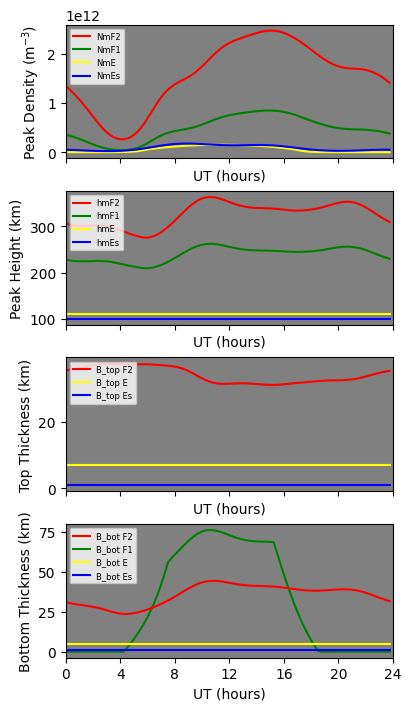

In [9]:
plot_dir = '/Users/vmakarevich/Documents/GitHub/PyIRI/docs/examples/Figs/'

# Make sure alon and alat contains lon_plot and lat_plot
lon_plot = 10
lat_plot = 20
plot.PyIRI_plot_1location_diurnal_par(f2, f1, e_peak, es_peak, alon, alat,
lon_plot, lat_plot, ahr, plot_dir,
plot_name='PyIRI_diurnal.png')

14. Plot electron density as a function of time.

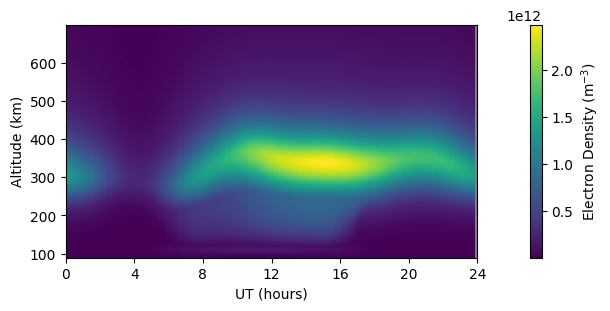

In [10]:
plot.PyIRI_plot_1location_diurnal_density(edp, alon, alat, lon_plot, lat_plot,
aalt, ahr, plot_dir, plot_name='PyIRI_EDP_diurnal.png')
